In [1]:
import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import innvestigate
# This is required for innvestigate and must be called before models are loaded.
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
#import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.signal import butter, sosfilt
from tensorflow.keras.models import load_model

2025-08-13 13:34:01.573578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-13 13:34:01.690164: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 13:34:01.724678: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
In_name = "TS_anom" #
Out_name = "FLNT_anom" #
#Out_name = "TOA_anom" #


#====================== Here is 1D data ===============================#
# Paths to the datasets
# file_hist = "E:\\Yue\\CESM2\\test\\test.CESM2-historical.ens-mean.ANN.1850-2014.new.nc"
# file_2xCO2 = "E:\\Yue\\test\\test.2xCO2.ANN.new.nc"
# file_4xCO2 = "E:\\Yue\\CESM2\\test\\test.CESM2-4xCO2.ANN.nc"


######### CESM1 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.FLNT.ANN.new.nc"
######### CESM1 #########

'''
######### CESM2 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.FLNT.ANN.nc"
#file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
######### CESM2 #########
'''
#====================== End of 1D data ================================#

#====================== here is 2D data ===============================#

#====================== End of 1D data ================================#

# === Load historical data ===
ds_hist = xr.open_dataset(file_hist, engine="netcdf4")
print("Historical dataset loaded:", ds_hist)

Historical dataset loaded: <xarray.Dataset>
Dimensions:   (lon: 288, lat: 192, time: 181)
Coordinates:
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time      (time) int64 1920 1921 1922 1923 1924 ... 2096 2097 2098 2099 2100
Data variables:
    TS        (time, lat, lon) float32 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
    TS_anom   (time, lat, lon) float32 ...
Attributes:
    ERF:      ERF = F - F_ctrl; my old CAM5 forcing run at /glade/campaign/un...
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu.ipynb
    author:   Y. Dong, 03/23/2025


In [3]:
lat = ds_hist["lat"]
lon = ds_hist["lon"]

time_hist = ds_hist["time"] 

######### CESM2 #########
#time_hist = [date.year for date in time_hist.values] #for C2 data
######### CESM2 #########

######### CESM1 #########
time_hist = time_hist.values #for C1 data
######### CESM1 #########

TS_hist = ds_hist[In_name]
TOA_hist = ds_hist["TOA_anom"].values

# === Load 2xCO2 data ===
# ds_2xCO2 = xr.open_dataset(file_2xCO2)
# print("2xCO2 dataset loaded:", ds_2xCO2)

# time_2xCO2 = ds_2xCO2["year"]
# TS_2xCO2 = ds_2xCO2[In_name]
# TOA_2xCO2 = ds_2xCO2[Out_name].values

# === Load 4xCO2 data ===
ds_4xCO2 = xr.open_dataset(file_4xCO2, engine="netcdf4")
print("4xCO2 dataset loaded:", ds_4xCO2)


# time_4xCO2_coords = ds_4xCO2["year"]
# time_4xCO2 = time_4xCO2_coords.values

'''
######### CESM2 #########
time_4xCO2 = ds_4xCO2["time"] 
time_4xCO2 = [date.year for date in time_4xCO2.values] #for C2 data
######### CESM2 #########
'''
######### CESM1 #########
time_4xCO2 = ds_4xCO2["year"] 
time_4xCO2 = time_4xCO2.values #C1 data
######### CESM1 #########

TS_4xCO2 = ds_4xCO2[In_name]
TOA_4xCO2 = ds_4xCO2[Out_name].values

# Optional: Print shapes to verify
print("TS_hist shape:", TS_hist.shape)
# print("TS_2xCO2 shape:", TS_2xCO2.shape)
print("TS_4xCO2 shape:", TS_4xCO2.shape)

4xCO2 dataset loaded: <xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, year: 150)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1996 1997 1998 1999
Data variables:
    TS_anom    (year, lat, lon) float64 ...
    FLNT_anom  (year) float64 ...
Attributes:
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu.ipynb
    note:     all fluxes are positive downward (TOA = FSNT + FLNT)
TS_hist shape: (181, 192, 288)
TS_4xCO2 shape: (150, 192, 288)


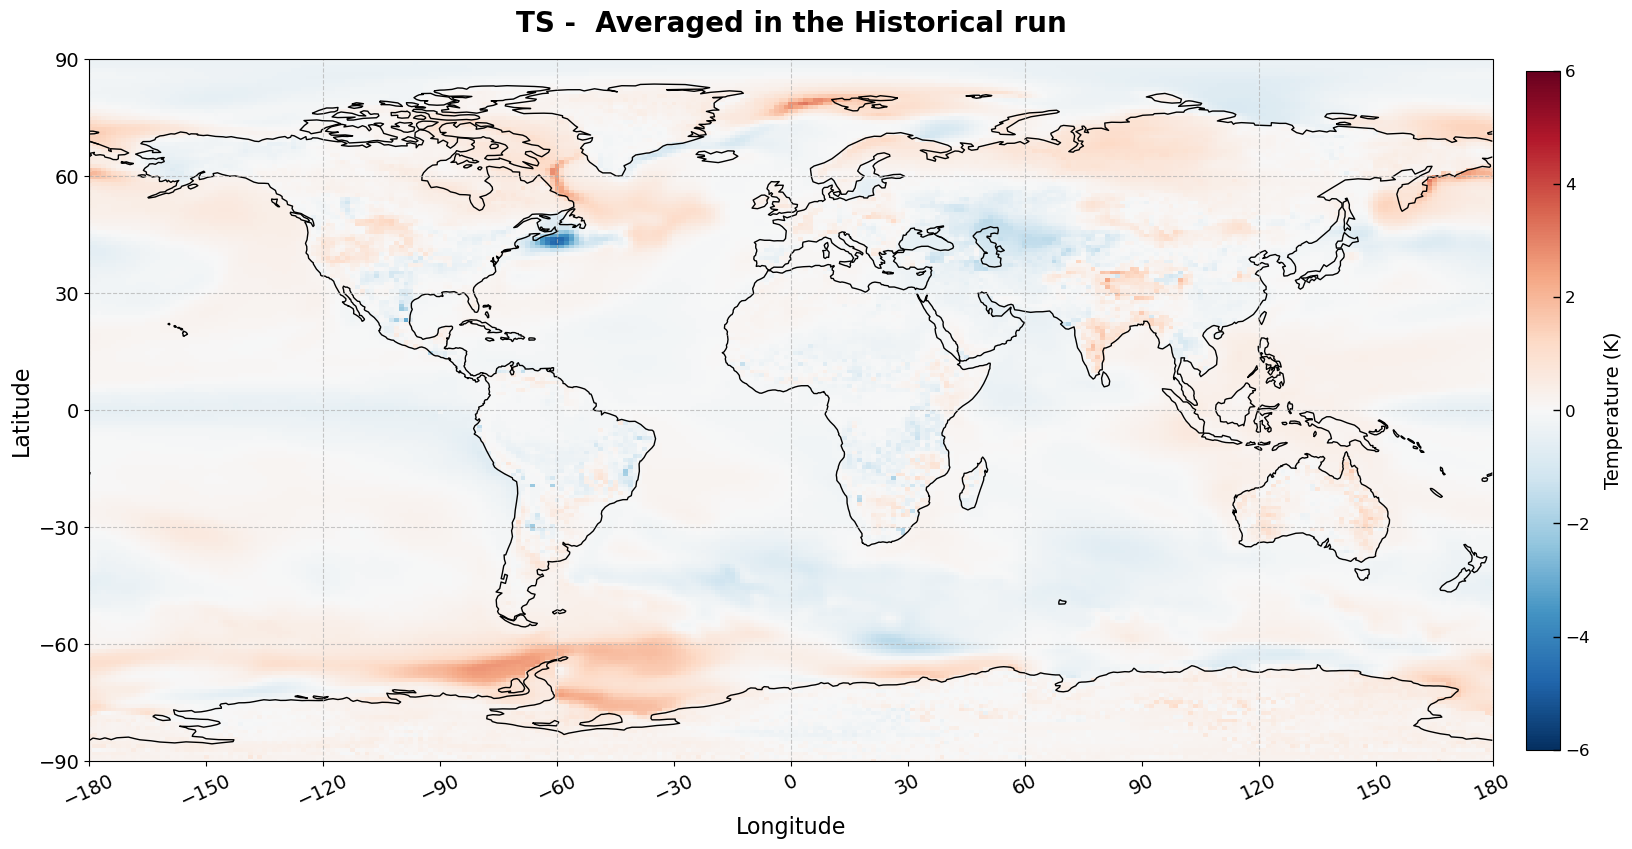

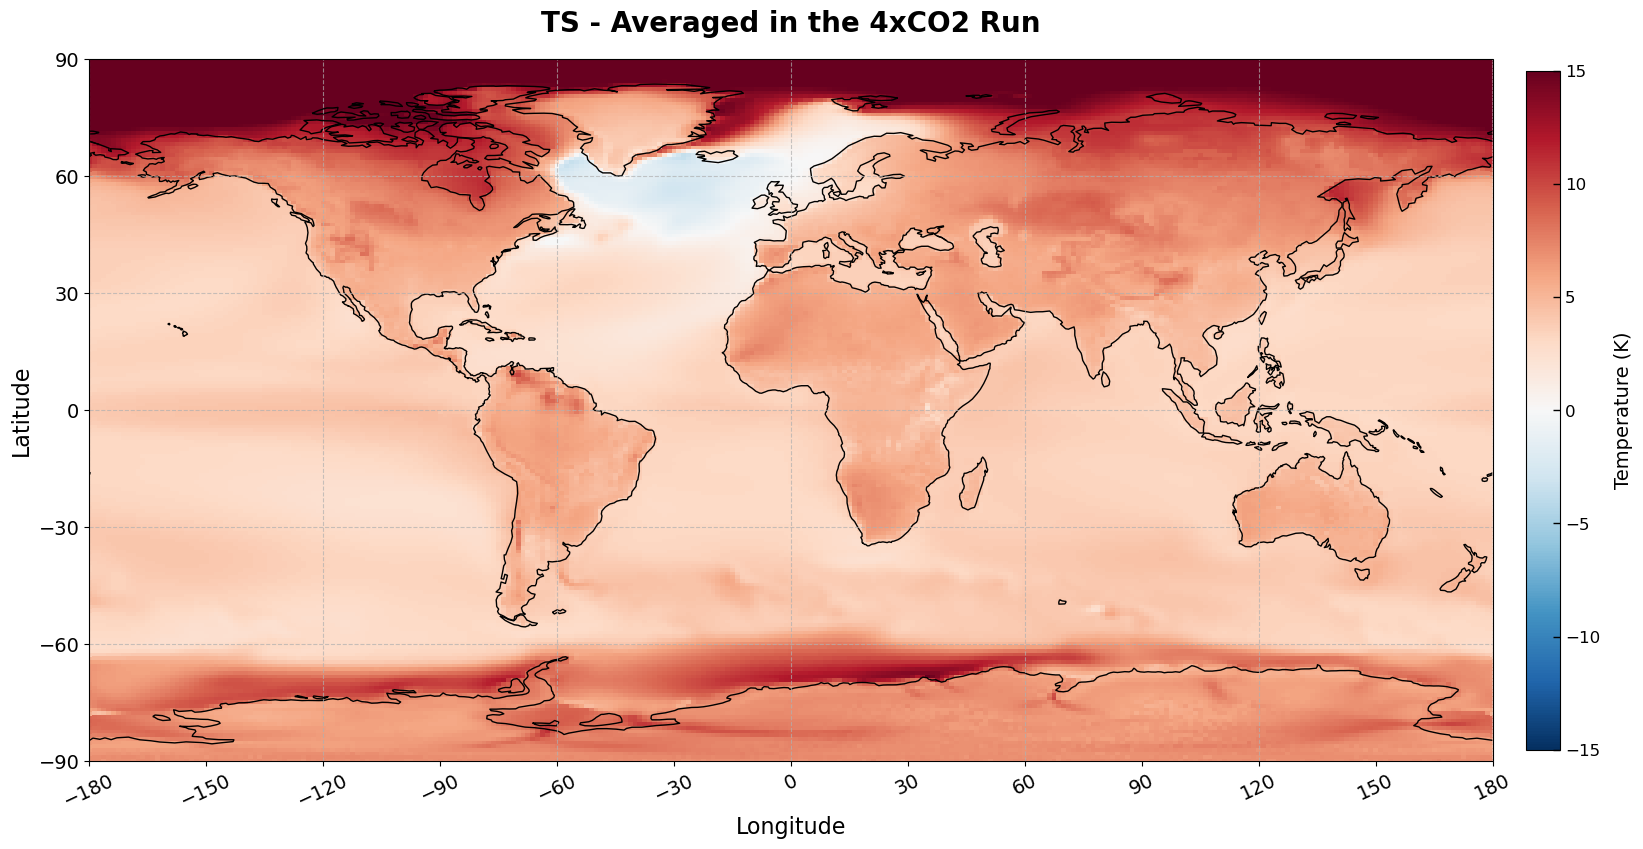

In [4]:
def plot_global_map(lon, lat, data2d, title, cbar_label="Temperature (K)", cmap="RdBu_r", vmin=None, vmax=None):
    """
    Plot a 2D global map using Cartopy with enhanced styling and colorbar.

    Parameters:
        lon (array): Longitudes
        lat (array): Latitudes
        data2d (2D array): Data to plot (must match lat/lon)
        title (str): Plot title
        cbar_label (str): Colorbar label
        cmap (str): Colormap
        vmin, vmax (float): Optional color scale limits
    """
    fig = plt.figure(figsize=(18, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the data
    pcm = ax.pcolormesh(lon, lat, data2d, cmap=cmap, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
    cbar.set_label(cbar_label, fontsize=14, labelpad=10)
    cbar.ax.tick_params(labelsize=12, direction='in', length=5, width=1)

    # Coastlines and grid
    ax.coastlines(resolution="110m", linewidth=1)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {"size": 13}
    gl.ylabel_style = {"size": 13}

    # Axis ticks
    ax.set_xticks(range(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.tick_params(axis="both", which="major", labelsize=14)
    plt.xticks(rotation=25, ha="center")

    # Title and labels
    ax.set_title(title, fontsize=20, fontweight="bold", pad=20)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

    plt.tight_layout()
    plt.show()





# Historical mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    # data2d=np.mean(ds_hist[In_name], axis=0),
    data2d=ds_hist[In_name][0,:,:],
    title="TS -  Averaged in the Historical run",
    vmin=-6, vmax=6
)

# 2xCO2 mean TS
# plot_global_map(
#     lon=lon,
#     lat=lat,
#     data2d=np.mean(ds_2xCO2[In_name], axis=0),
#     title="TS - Averaged in the 2xCO2 Run",
#     vmin=-12, vmax=12
# )


# 4xCO2 mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    data2d=np.mean(ds_4xCO2[In_name], axis=0),
    title="TS - Averaged in the 4xCO2 Run",
    vmin=-15, vmax=15
)



In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import ndimage # New import for spatial smoothing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def calculate_trend_and_significance_temporal_smooth(relevance_data, time_axis, p_value_threshold=0.05, window_size=5):
    """
    Applies temporal smoothing (running mean) to relevance time series before
    calculating the linear trend and significance.
    'window_size' is the number of years for the running mean.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    num_time, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool)

    print(f"    Calculating trends with temporal smoothing (window={window_size}) for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            
            if np.all(np.isfinite(relevance_timeseries)):
                # Apply temporal smoothing using a rolling mean
                # Using pandas for convenient rolling mean with handling of edges
                series = pd.Series(relevance_timeseries)
                smoothed_timeseries = series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
                
                # Filter out NaNs that might be introduced by rolling mean if window is large
                valid_indices = ~np.isnan(smoothed_timeseries)
                
                if np.sum(valid_indices) > 1: # Need at least 2 points for regression
                    current_time_axis = time_axis[valid_indices]
                    current_data = smoothed_timeseries[valid_indices]
                    
                    if len(current_data) > 1: # Still need at least 2 points after NaN removal
                        lin_reg_result = stats.linregress(x=current_time_axis, y=current_data)
                        trend_map[y, x] = lin_reg_result.slope
                        if lin_reg_result.pvalue < p_value_threshold:
                            significance_mask[y, x] = True
    print("    Trend and significance calculation with temporal smoothing complete.")
    return trend_map, significance_mask

def calculate_trend_and_significance(relevance_data, time_axis, p_value_threshold=0.1):
    """
    Calculates the linear trend (slope) and a significance mask
    at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool) # Mask for significance

    print(f"    Calculating trends and significance for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                lin_reg_result = stats.linregress(x=time_axis, y=relevance_timeseries)
                trend_map[y, x] = lin_reg_result.slope
                if lin_reg_result.pvalue < p_value_threshold:
                    significance_mask[y, x] = True
    print("    Trend and significance calculation complete.")
    return trend_map, significance_mask

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    smoothed_map = ndimage.gaussian_filter(data2d, sigma=sigma)
    print("    Smoothing complete.")
    return smoothed_map

In [6]:
ds_hist[In_name][0,:,:]

<xarray.DataArray 'TS_anom' (lat: 192, lon: 288)>
[55296 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
    time     int64 1920
Attributes:
    units:    K
    note:     TS_anom = TS_his - TS_ref
    ref:      B1850C5CN mean state

In [15]:
### load the mean and STD calculated in the Pre-industrial control run for normalization

# Paths to the datasets and trained model


########### CESM1 Model ##########
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #original model

#C1 FLNT
path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_for_FLNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FLNT_anom"

#new model(1) -wrong one
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #wrong place but the model is for data 1
######### CESM1 #########

########## CESM2 Model ######
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_for_FSNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FSNT"
#FLNT
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_for_FLNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FLNT_anom"
######### CESM2 #########

normalization= sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))

X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']


TS_hist_norm = (TS_hist-X_mean)/X_std.squeeze()
# TS_2xCO2_norm = (TS_2xCO2-X_mean)/X_std.squeeze()
TS_4xCO2_norm = (TS_4xCO2-X_mean)/X_std.squeeze()

TS_hist_norm = TS_hist_norm.values[..., tf.newaxis]
# TS_2xCO2_norm = TS_2xCO2_norm.values[..., tf.newaxis]
TS_4xCO2_norm = TS_4xCO2_norm.values[..., tf.newaxis]

print(X_mean)
print(X_std)


print(y_mean)
print(y_std)

[[-2.10623824e-04 -3.53298992e-06 -9.22559411e-05 ...  3.87442778e-05
  -2.56544208e-05 -1.04447725e-04]
 [ 1.70041036e-04 -1.25976090e-04  2.52858736e-04 ...  4.71912563e-06
   2.21883631e-04  8.57152554e-05]
 [ 3.45589127e-04 -1.95924207e-04 -4.28872809e-05 ... -1.06506515e-04
  -1.65177873e-04  1.70413812e-04]
 ...
 [-1.88519334e-04 -5.27491502e-05 -1.12945541e-04 ...  2.52350379e-04
  -4.53866378e-05  2.37345768e-04]
 [ 2.46504438e-04 -1.04337581e-04  1.80885709e-05 ...  2.75547791e-04
   1.28102663e-04 -3.28729038e-06]
 [-1.15351701e-04 -7.93524814e-05 -8.38174383e-05 ... -1.90018953e-04
  -2.44818424e-04 -1.57874674e-04]]
[[0.53236276 0.5272246  0.52714384 ... 0.52715605 0.5320779  0.5270208 ]
 [0.5789423  0.5785266  0.5860141  ... 0.5794204  0.58237875 0.583376  ]
 [0.6280227  0.61705714 0.613267   ... 0.6247527  0.6240835  0.6179534 ]
 ...
 [1.0660722  1.0682158  1.0702783  ... 1.060526   1.0623665  1.06411   ]
 [1.0350558  1.0358475  1.0366569  ... 1.0323555  1.033299   1.0342

In [16]:
from tensorflow.keras import backend as K
# load the neural network trained from Pre-industrial control simulation

n_folds = 5
n_ensembles = 1

pred_hist_ALL = np.empty((TOA_hist.shape[0],0))
# pred_2xCO2_ALL = np.empty((TOA_2xCO2.shape[0],0))
pred_4xCO2_ALL = np.empty((TOA_4xCO2.shape[0],0))


for fold_no in range(1,n_folds+1):

    pred_hist = np.zeros((TOA_hist.shape[0],1));
    # pred_2xCO2 = np.zeros((TOA_2xCO2.shape[0],1));
    pred_4xCO2 = np.zeros((TOA_4xCO2.shape[0],1));
    for ens_no in range(1,n_ensembles+1):
        K.clear_session() # Clears the Keras session and TensorFlow graph
        gc.collect()  
        Model = load_model(os.path.join(path_PIc,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
        pred_hist = pred_hist+ Model.predict(TS_hist_norm)
        # pred_2xCO2 = pred_2xCO2+ Model.predict(TS_2xCO2_norm)
        pred_4xCO2 = pred_4xCO2+ Model.predict(TS_4xCO2_norm)
        
    pred_hist = pred_hist/n_ensembles
    # pred_2xCO2 = pred_2xCO2/n_ensembles
    pred_4xCO2 = pred_4xCO2/n_ensembles


# re-scale the prediction from the neural network
    pred_hist = pred_hist*y_std + y_mean
    # pred_2xCO2 = pred_2xCO2*y_std + y_mean
    pred_4xCO2 = pred_4xCO2*y_std + y_mean



    pred_hist_ALL = np.concatenate(( pred_hist_ALL,pred_hist),axis = 1)
    # pred_2xCO2_ALL = np.concatenate(( pred_2xCO2_ALL,pred_2xCO2),axis = 1)
    pred_4xCO2_ALL = np.concatenate(( pred_4xCO2_ALL,pred_4xCO2),axis = 1)




2025-08-13 13:41:23.961186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0
2025-08-13 13:41:24.898569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0
2025-08-13 13:41:25.832061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0
2025-08-13 13:41:26.807731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id

In [17]:
def plot_predictions(time, truth, preds, title):
    """
    Plots the ground truth, mean prediction, and individual model predictions with transparency.

    Parameters:
        time (array-like): Time axis values.
        truth (array-like): Ground truth values.
        preds (2D array): Predictions from ensemble or multiple models (shape: time x ensemble).
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot truth
    ax.plot(time, truth, label="Truth", color="C0", linewidth=2)

    # Plot mean prediction
    mean_pred = np.mean(preds, axis=1)
    ax.plot(time, mean_pred, label="Prediction (Mean)", color="C1", linewidth=1.8)

    # Plot individual models
    for i in range(preds.shape[1]):
        ax.plot(time, preds[:, i], linewidth=1, alpha=0.5,
                label="Prediction (CV" + str(i+1) + ")")

    # Style
    ax.set_xlabel("Time (Year)", fontsize=16)
    ax.set_ylabel(Out_name, fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, fontsize=18, pad=15)
    ax.legend(fontsize=14, loc="best")

    # R² annotation
    r2 = r2_score(truth, mean_pred)
    ax.text(0.02, 0.95, f"$R^2$ = {r2:.3f}", transform=ax.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    plt.tight_layout()
    plt.show()


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
from scipy.stats import pearsonr

def plot_predictions_twin_axes(time, truth, preds, title):
    """
    Plots the ground truth and predictions on separate y-axes with a combined legend.
    """
    fig, ax1 = plt.subplots(figsize=(16, 8)) # Increased size for better legend visibility

    # --- Left Y-Axis (for Truth) ---
    color = 'C0'
    ax1.set_xlabel("Time (Year)", fontsize=16)
    ax1.set_ylabel("Truth (FSNT_anom)", color=color, fontsize=16)
    # Plot truth and store its handle for the legend
    line1 = ax1.plot(time, truth, label="Truth", color=color, linewidth=2.5)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
    ax1.grid(True, linestyle="--", alpha=0.5)

    # --- Right Y-Axis (for Predictions) ---
    ax2 = ax1.twinx()
    color = 'C1'
    ax2.set_ylabel("Prediction", color=color, fontsize=16)
    mean_pred = np.mean(preds, axis=1)
    # Plot mean prediction and store its handle
    line2 = ax2.plot(time, mean_pred, label="Prediction (Mean)", color=color, linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

    # Plot individual models and store their handles
    other_lines = []
    for i in range(preds.shape[1]):
        line = ax2.plot(time, preds[:, i], linewidth=1, alpha=0.3,
                        label=f"Prediction (CV{i+1})")
        other_lines.extend(line)

    # --- Combined Legend ---
    # Combine all the line handles and labels into one legend
    all_lines = line1 + line2 + other_lines
    labels = [l.get_label() for l in all_lines]
    ax1.legend(all_lines, labels, loc='lower right', fontsize=12)

    # --- Title and R² Annotation ---
    truth_flat = truth.flatten()
    pred_flat = mean_pred.flatten()
    correlation_score, _ = stats.pearsonr(truth, mean_pred)

    ax1.text(0.02, 0.95, f"Correlation = {correlation_score:.3f}", transform=ax1.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    
        
    ax1.set_title(title, fontsize=20, pad=15)
    fig.tight_layout()
    plt.show()

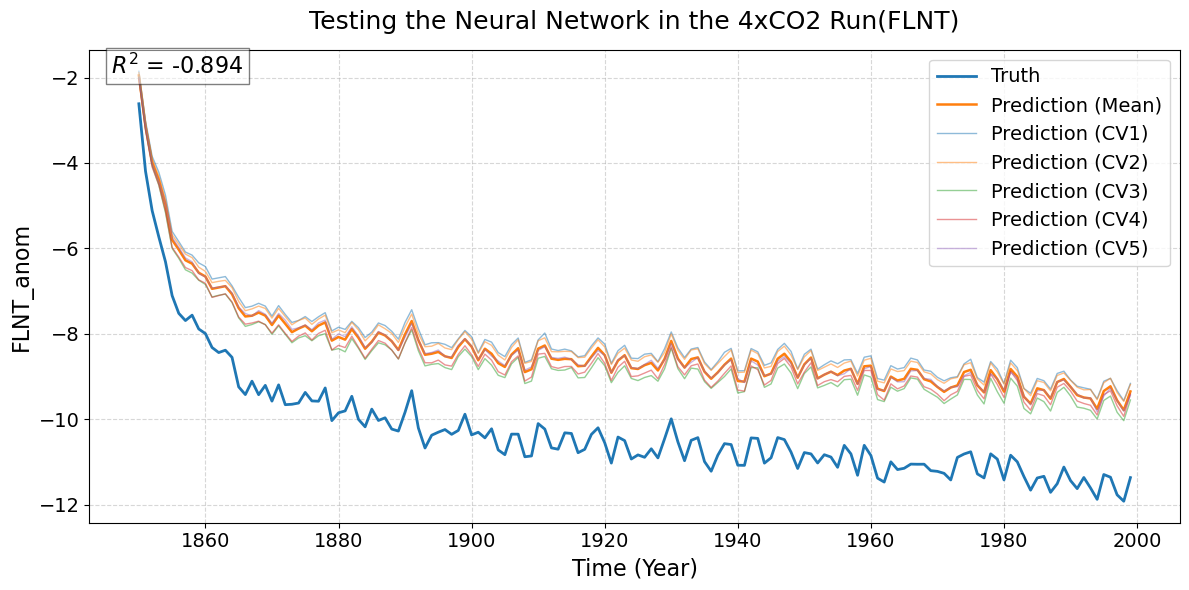

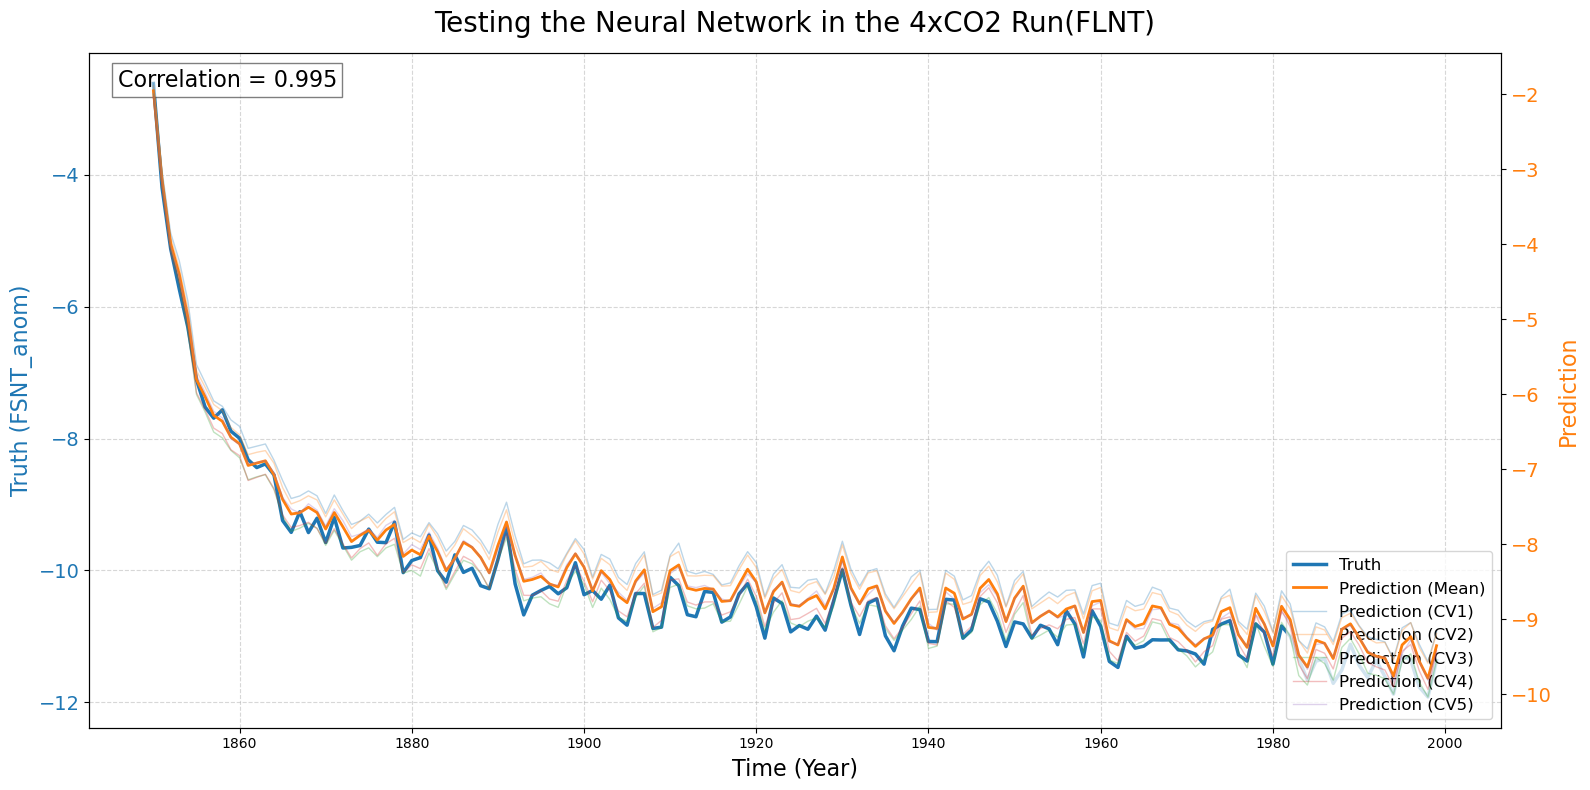

In [19]:
# plot_predictions(time_hist, TOA_hist, pred_hist_ALL,
#                 "Testing the Neural Network in the Historical Run")


plot_predictions(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run(FLNT)")


plot_predictions_twin_axes(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run(FLNT)")



▶️ PROCESSING LRP FOR SCENARIO: HISTORICAL
    Analyzing model: model_fold1_ens1.h5


2025-08-13 13:41:29.342295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5


2025-08-13 13:41:30.816845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5


2025-08-13 13:41:32.297038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5


2025-08-13 13:41:33.787413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5


2025-08-13 13:41:35.294053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


✅ Full attribution map saved to: attribution_map_historical.npy


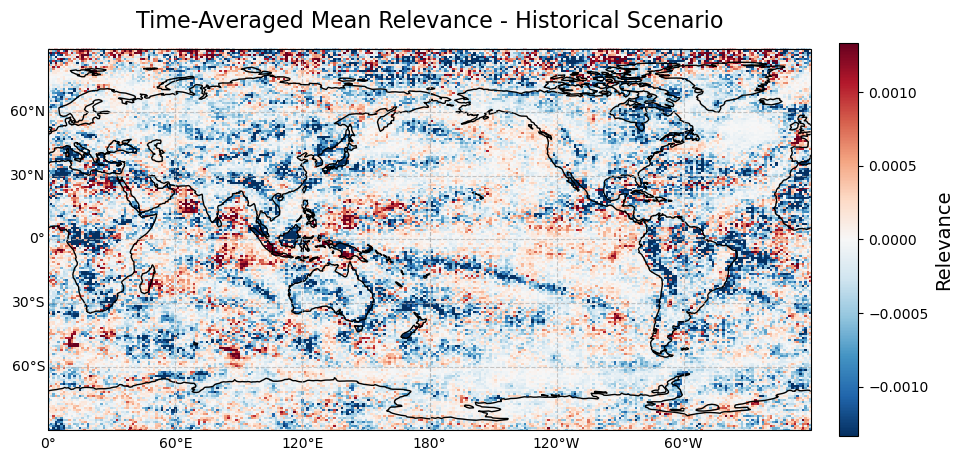


▶️ PROCESSING LRP FOR SCENARIO: 4XCO2
    Analyzing model: model_fold1_ens1.h5


2025-08-13 13:41:38.707003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5


2025-08-13 13:41:40.175447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5


2025-08-13 13:41:41.623942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5


2025-08-13 13:41:43.114196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5


2025-08-13 13:41:44.594065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30538 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


✅ Full attribution map saved to: attribution_map_4xCO2.npy


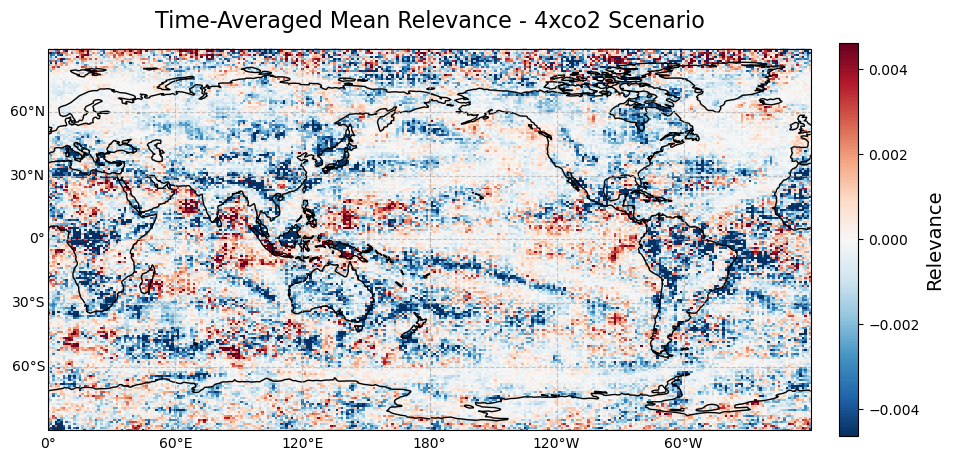

In [20]:
def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance"):
    """
    Plots a 2D global map using Cartopy, centered on the Pacific Ocean,
    with a tight, percentile-based color scale.
    """
    # Set color scale limit based on the 98th percentile to see patterns clearly
    vmax = np.nanpercentile(np.abs(data2d), 95)
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()

def ensemble_lrp_analyze(model_dir, num_folds, data_to_analyze):
    """
    Loads each model in an ensemble, generates its LRP map, and returns
    the averaged map from all models.
    """
    all_relevance_maps = []
    for i in range(1, num_folds + 1):
        K.clear_session(); gc.collect()
        model_path = os.path.join(model_dir, f'model_fold{i}_ens1.h5')
        print(f"    Analyzing model: {os.path.basename(model_path)}")
        try:
            model = load_model(model_path)
            # The analyzer needs the model without the final activation if it's not linear
            analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue
    
    if not all_relevance_maps:
        return None
        
    # Stack along a new axis and compute the mean across the folds
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

# --- 4. Main LRP Analysis and Plotting ---
TEST_SCENARIOS = {
    "historical": TS_hist_norm,
    "4xCO2": TS_4xCO2_norm
}

for scenario, data in TEST_SCENARIOS.items():
    print(f"\n======================================================")
    print(f"▶️ PROCESSING LRP FOR SCENARIO: {scenario.upper()}")
    print(f"======================================================")
    
    # Generate the full [time, lat, lon] attribution map
    attribution_map = ensemble_lrp_analyze(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data
    )
    
    if attribution_map is not None:
        # Squeeze out the channel dimension for saving and plotting
        attribution_map = attribution_map.squeeze()
        
        # Save the full attribution map for future analyses
        output_filename = f"attribution_map_{scenario}.npy"
        np.save(output_filename, attribution_map)
        print(f"✅ Full attribution map saved to: {output_filename}")
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} Scenario"
        )

--- Starting Lambda Map Calculation ---
    Loading data...
✅ Data loaded successfully.

    Step 1: Calculating area-weighted global mean...
✅ Global mean calculated.

    Step 2: Scaling LRP relevance map...
✅ LRP map scaled.

    Step 3: Calculating local lambda contribution map...
✅ Lambda map calculated.

    Step 4: Plotting the final map...


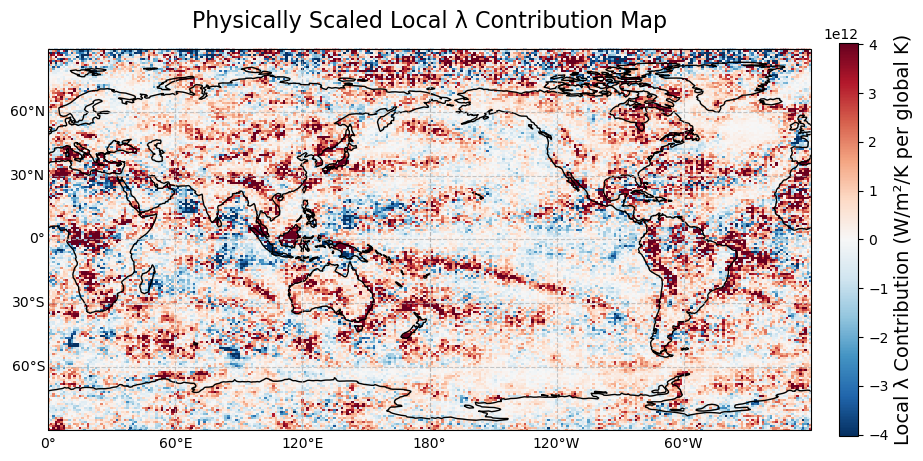

In [21]:
# ==========================================================
# Physically Scaled Local Lambda Contribution Map Calculation
# ==========================================================
import numpy as np
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# --- 1. Configuration: Please fill in these paths ---

# Path to the out-of-sample test file containing the INPUT data (e.g., TS_anom)
path_test_input = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
input_var_name = "TS_anom"

# Path to the saved LRP relevance map (.npy file) for the same scenario
path_lrp_map = "attribution_map_historical.npy"

# Path to the directory of the trained model that generated the LRP map
# This is needed to get the normalization constant (y_std).
path_to_model_dir = path_PIc


# --- 2. Helper Functions ---

def calculate_area_weighted_global_mean(data_3d, lat_coords):
    """
    Calculates the area-weighted global mean from a [time, lat, lon] array.
    """
    weights_lat = np.cos(np.deg2rad(lat_coords))
    mean_over_lon = np.mean(data_3d, axis=2)
    global_mean_timeseries = np.average(mean_over_lon, axis=1, weights=weights_lat)
    return global_mean_timeseries

def calculate_local_lambda_map(local_relevance_scaled, global_mean_tsa):
    """
    Calculates the physically-scaled local lambda contribution map.
    """
    sum_relevance_map = np.sum(local_relevance_scaled, axis=0)
    sum_centered_tsa = np.sum(global_mean_tsa - np.mean(global_mean_tsa))
    local_lambda_contribution_map = sum_relevance_map / sum_centered_tsa
    return local_lambda_contribution_map

def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label=""):
    """
    Plots a 2D global map with a sensitive, percentile-based color scale.
    """
    vmax = np.nanpercentile(np.abs(data2d), 95) # Changed from 98 to 95
    vmin = -vmax
    # ---------------------------------------------------------
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    
    total_sum = np.nansum(data2d)
    # Add the sum as text to the top-left corner of the plot
    #ax.text(0.02, 0.95, f"Sum = {total_sum:.2f}", transform=ax.transAxes,
    #        fontsize=14, bbox=dict(facecolor="white", edgecolor="black", alpha=0.7))
    plt.show()


# --- 3. Main Analysis ---
print("--- Starting Lambda Map Calculation ---")

try:
    # Load the necessary data
    print("    Loading data...")
    ds_input = xr.open_dataset(path_test_input)
    ts_anomaly_data = ds_input[input_var_name].values
    lat = ds_input['lat'].values
    lon = ds_input['lon'].values
    
    lrp_map = np.load(path_lrp_map)
    
    normalization = sio.loadmat(os.path.join(path_to_model_dir, 'Normalization.mat'))
    y_std_scalar = float(normalization['y_std'][0, 0])
    print("✅ Data loaded successfully.")

    # Step 1: Calculate the global mean surface temperature anomaly time series
    print("\n    Step 1: Calculating area-weighted global mean...")
    ts_mean_timeseries = calculate_area_weighted_global_mean(ts_anomaly_data, lat)
    print("✅ Global mean calculated.")

    # Step 2: Scale the LRP relevance map
    print("\n    Step 2: Scaling LRP relevance map...")
    lrp_map_scaled = lrp_map * y_std_scalar
    print("✅ LRP map scaled.")

    # Step 3: Calculate the local lambda contribution map
    print("\n    Step 3: Calculating local lambda contribution map...")
    lambda_map = calculate_local_lambda_map(lrp_map_scaled, ts_mean_timeseries)
    print("✅ Lambda map calculated.")
    
    # Step 4: Plot the final result
    print("\n    Step 4: Plotting the final map...")
    plot_pacific_centered_map(
        lon, lat, lambda_map,
        title="Physically Scaled Local λ Contribution Map",
        cbar_label="Local λ Contribution (W/m²/K per global K)"
    )

except FileNotFoundError:
    print(f"❌ ERROR: A file was not found. Please double-check your paths:\n"
          f"  Input Path: {path_test_input}\n"
          f"  LRP Path: {path_lrp_map}\n"
          f"  Model Path: {path_to_model_dir}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")